In [ ]:
#!/usr/bin/env python3

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup
from tqdm import tqdm  # For progress bar
import argparse
import matplotlib.lines as mlines
import os

# Function to process variable-length descriptors into fixed-length representations
def process_descriptor(descriptor_series):
    """
    Process variable-length descriptors into fixed-length representations.

    Parameters:
    - descriptor_series (Series): Pandas Series containing descriptors (arrays of variable length).

    Returns:
    - features (ndarray): 2D numpy array of shape (n_samples, fixed_length)
    """
    # Initialize a list to store processed features
    processed_features = []
    for descriptor in descriptor_series:
        # Ensure the descriptor is a numpy array
        descriptor = np.array(descriptor)
        # Compute summary statistics
        mean = np.mean(descriptor)
        std = np.std(descriptor)
        min_val = np.min(descriptor)
        max_val = np.max(descriptor)
        # Concatenate the summary statistics into a fixed-length vector
        feature_vector = np.array([mean, std, min_val, max_val])
        processed_features.append(feature_vector)
    # Stack the processed features into a 2D array
    features = np.vstack(processed_features)
    return features

# Load parquet files and extract relevant features
def load_and_extract_features(file_list):
    """
    Load parquet files and extract relevant features.

    Parameters:
    - file_list (list): List of file paths to parquet files.

    Returns:
    - combined_df (DataFrame): Combined DataFrame with relevant features.
    """
    combined_data = []

    for file in tqdm(file_list, desc='Processing files'):
        # Read only necessary columns
        columns_to_read = [
            'descriptors.soap_gen',
            'descriptors.acsf_gen',
            'descriptors.xrd_gen.iq',
            'dataset_name',
            'spacegroup',
            'seq_len'
        ]
        df = pd.read_parquet(file)

        # Convert feature columns to numpy arrays
        for col in ['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq']:
            df[col] = df[col].map(lambda x: np.array(x) if isinstance(x, list) else x)

        combined_data.append(df)

    try:
        combined_df = pd.concat(combined_data, ignore_index=True)
    except ValueError as e:
        print(f"Error concatenating data frames: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if concatenation fails

    # Convert 'spacegroup' to integer numbers
    def get_spacegroup_int(sg):
        try:
            return SpaceGroup(sg).int_number
        except:
            return np.nan

    combined_df['spacegroup_int'] = combined_df['spacegroup'].apply(get_spacegroup_int)

    return combined_df

# Extract individual feature matrices
def get_feature_matrices(df):
    """
    Extract individual feature matrices for SOAP, ACSF, XRD, and combined features.

    Parameters:
    - df (DataFrame): DataFrame containing feature columns.

    Returns:
    - feature_dict (dict): Dictionary containing individual and combined feature matrices.
    - filtered_df (DataFrame): DataFrame after filtering out NaN values.
    """
    # Filter out rows where any of the descriptor columns are None or NaN
    filtered_df = df.dropna(subset=['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq'])

    if len(filtered_df) == 0:
        raise ValueError("No data left after filtering for NaN values.")

    # Process each descriptor column into fixed-length features
    soap_features = process_descriptor(filtered_df['descriptors.soap_gen'])
    acsf_features = process_descriptor(filtered_df['descriptors.acsf_gen'])

    # For XRD, get both summary features and full features
    xrd_features_summary = process_descriptor(filtered_df['descriptors.xrd_gen.iq'])
    xrd_features_full = np.vstack(filtered_df['descriptors.xrd_gen.iq'].values)

    print(f"SOAP features shape: {soap_features.shape}")
    print(f"ACSF features shape: {acsf_features.shape}")
    print(f"XRD summary features shape: {xrd_features_summary.shape}")
    print(f"XRD full features shape: {xrd_features_full.shape}")

    # Concatenate summary features for combined features
    combined_features = np.hstack([soap_features, acsf_features, xrd_features_summary])

    feature_dict = {
        'SOAP': soap_features,
        'ACSF': acsf_features,
        'XRD_Summary': xrd_features_summary,
        'XRD_Full': xrd_features_full,
        'Combined': combined_features
    }

    return feature_dict, filtered_df

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    """
    Perform dimensionality reduction on the feature matrix.

    Parameters:
    - features (ndarray): The feature matrix.
    - n_components (int): Number of components for PCA.

    Returns:
    - reduced_features (ndarray): Reduced feature matrix.
    - pca (PCA object): Trained PCA model.
    - scaler (StandardScaler object): Fitted scaler object.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)

    return reduced_features, pca, scaler

def filter_outliers_on_reduced_features(reduced_features, method='zscore', thresh=3.0):
    """
    Filter outliers based on the reduced features.

    Parameters:
    - reduced_features (ndarray): Reduced feature matrix (e.g., PCA components).
    - method (str): Method to use for outlier detection ('zscore' or 'iqr').
    - thresh (float): Threshold for outlier detection.

    Returns:
    - mask (ndarray): Boolean mask indicating which samples to keep.
    """
    if method == 'zscore':
        from scipy.stats import zscore
        z_scores = np.abs(zscore(reduced_features))
        mask = (z_scores < thresh).all(axis=1)
    elif method == 'iqr':
        Q1 = np.percentile(reduced_features, 25, axis=0)
        Q3 = np.percentile(reduced_features, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - thresh * IQR
        upper_bound = Q3 + thresh * IQR
        mask = np.all((reduced_features >= lower_bound) & (reduced_features <= upper_bound), axis=1)
    else:
        raise ValueError("Invalid method for outlier detection. Choose 'zscore' or 'iqr'.")

    return mask

def visualize_samples(reduced_features_dict, df_filtered_dict, save_path=None, separate_descriptor_path=None):
    """
    Visualize the samples after dimensionality reduction.

    Parameters:
    - reduced_features_dict (dict): Dictionary of reduced feature matrices.
    - df_filtered_dict (dict): Dictionary of filtered DataFrames for each descriptor.
    - save_path (str, optional): File path to save the combined plot.
    - separate_descriptor_path (str, optional): Directory to save individual descriptor plots.
    """
    sns.set(style='whitegrid')
    # Increase figure size
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), constrained_layout=True)
    axes = axes.flatten()
    descriptors = ['SOAP', 'ACSF', 'XRD_Summary', 'XRD_Full', 'Combined']

    # Adjust font sizes
    plt.rcParams.update({'font.size': 10})

    for idx, descriptor in enumerate(descriptors):
        if idx >= len(axes):
            break  # In case there are more descriptors than axes
        ax = axes[idx]
        reduced_features = reduced_features_dict[descriptor]
        df_filtered = df_filtered_dict[descriptor]

        # Create a DataFrame for plotting
        plot_df = pd.DataFrame({
            'PC1': reduced_features[:, 0],
            'PC2': reduced_features[:, 1],
            'Dataset': df_filtered['dataset_name'].values,
            'Spacegroup': df_filtered['spacegroup_int'].values,
            'Sequence Length': df_filtered['seq_len'].values
        })

        # Normalize the 'Spacegroup' data for the color mapping
        norm = plt.Normalize(plot_df['Spacegroup'].min(), plot_df['Spacegroup'].max())
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])

        # Create scatter plot without legend
        scatter = ax.scatter(
            plot_df['PC1'],
            plot_df['PC2'],
            c=plot_df['Spacegroup'],
            cmap='viridis',
            edgecolor='k',
            alpha=0.7
        )

        # Apply markers for 'Dataset'
        unique_datasets = plot_df['Dataset'].unique()
        markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '+']  # Extend as needed

        for i, dataset in enumerate(unique_datasets):
            idxs = plot_df['Dataset'] == dataset
            ax.scatter(
                plot_df.loc[idxs, 'PC1'],
                plot_df.loc[idxs, 'PC2'],
                marker=markers[i % len(markers)],
                facecolors='none',
                edgecolors='k',
                alpha=0.7,
                label=dataset
            )

        ax.set_title(f"{descriptor} Descriptor", fontsize=12)
        ax.set_xlabel('Principal Component 1', fontsize=10)
        ax.set_ylabel('Principal Component 2', fontsize=10)
        ax.tick_params(axis='both', which='major', labelsize=8)
        ax.grid(alpha=0.5)

        # Add legend with only 'Dataset'
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), title='Dataset', fontsize=8)

        # Save individual descriptor plots if required
        if separate_descriptor_path:
            if not os.path.exists(separate_descriptor_path):
                os.makedirs(separate_descriptor_path)
            descriptor_save_path = os.path.join(separate_descriptor_path, f"{descriptor}_descriptor_plot.png")
            fig_descriptor, ax_descriptor = plt.subplots(figsize=(10, 8))
            scatter = ax_descriptor.scatter(
                plot_df['PC1'],
                plot_df['PC2'],
                c=plot_df['Spacegroup'],
                cmap='viridis',
                edgecolor='k',
                alpha=0.7
            )
            for i, dataset in enumerate(unique_datasets):
                idxs = plot_df['Dataset'] == dataset
                ax_descriptor.scatter(
                    plot_df.loc[idxs, 'PC1'],
                    plot_df.loc[idxs, 'PC2'],
                    marker=markers[i % len(markers)],
                    facecolors='none',
                    edgecolors='k',
                    alpha=0.7,
                    label=dataset
                )

            ax_descriptor.set_title(f"{descriptor} Descriptor", fontsize=12)
            ax_descriptor.set_xlabel('Principal Component 1', fontsize=10)
            ax_descriptor.set_ylabel('Principal Component 2', fontsize=10)
            ax_descriptor.tick_params(axis='both', which='major', labelsize=8)
            ax_descriptor.grid(alpha=0.5)

            # Add colorbar
            cbar = plt.colorbar(sm, ax=ax_descriptor)
            cbar.set_label('Spacegroup Number', fontsize=10)

            # Add legend with only 'Dataset'
            handles, labels = ax_descriptor.get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            ax_descriptor.legend(by_label.values(), by_label.keys(), title='Dataset', fontsize=8)

            plt.savefig(descriptor_save_path, bbox_inches='tight')
            plt.close(fig_descriptor)

    # Remove empty subplots
    for idx in range(len(descriptors), len(axes)):
        fig.delaxes(axes[idx])

    # Adjust font sizes in the main figure
    for ax in axes:
        ax.title.set_fontsize(12)
        ax.xaxis.label.set_fontsize(10)
        ax.yaxis.label.set_fontsize(10)
        ax.tick_params(axis='both', which='major', labelsize=8)

    # Add colorbar to the figure
    cbar = fig.colorbar(sm, ax=axes.tolist(), fraction=0.02, pad=0.02)
    cbar.set_label('Spacegroup Number', fontsize=10)

    # Adjust layout
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()

_name__ == "__main__":
# Parse command-line arguments
parser = argparse.ArgumentParser(description="Process and visualize .eval files")
parser.add_argument('files', nargs='+', help="List of .eval file paths to process")
parser.add_argument('--save', type=str, default=None, help="File path to save the combined plot")
parser.add_argument('--save_individual', type=str, default=None, help="Directory to save individual descriptor plots")
parser.add_argument('--remove_outliers', action='store_true', help="Option to remove outliers after PCA")
parser.add_argument('--outlier_method', type=str, default='zscore', choices=['zscore', 'iqr'], help="Method for outlier detection ('zscore' or 'iqr')")
parser.add_argument('--outlier_thresh', type=float, default=3.0, help="Threshold for outlier detection")
args = parser.parse_args()

# Load and extract relevant features
df = load_and_extract_features(args.files)

# Extract individual and combined feature matrices
feature_dict, df = get_feature_matrices(df)

# Initialize dictionaries to store reduced features and filtered DataFrames
reduced_features_dict = {}
df_filtered_dict = {}

for key in feature_dict:
    print(f"Performing PCA on {key} features...")
    reduced_features, pca, scaler = perform_dimensionality_reduction(feature_dict[key], n_components=2)

    # Outlier removal after PCA
    if args.remove_outliers:
        print(f"Removing outliers from {key} reduced features...")
        mask = filter_outliers_on_reduced_features(
            reduced_features, method=args.outlier_method, thresh=args.outlier_thresh
        )
        print(f"Samples before outlier removal: {len(reduced_features)}")
        print(f"Samples after outlier removal: {np.sum(mask)}")

        if np.sum(mask) == 0:
            raise ValueError(f"No data left after outlier removal on {key} features.")

        # Filter reduced features and DataFrame
        reduced_features = reduced_features[mask]
        df_filtered_key = df.iloc[mask].reset_index(drop=True)
        df_filtered_dict[key] = df_filtered_key
    else:
        df_filtered_dict[key] = df.copy()

    # Store the filtered reduced features
    reduced_features_dict[key] = reduced_features

# Visualize the samples
visualize_samples(reduced_features_dict, df_filtered_dict, save_path=args.save, separate_descriptor_path=args.save_individual)


In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup
from tqdm import tqdm  # For progress bar

import matplotlib.lines as mlines

# Load parquet files and extract relevant features
def load_and_extract_features(file_list):
    """
    Load parquet files and extract relevant features.

    Parameters:
    - file_list (list): List of file paths to parquet files.

    Returns:
    - combined_df (DataFrame): Combined DataFrame with relevant features.
    """
    combined_data = []

    for file in tqdm(file_list, desc='Processing files'):
        # Read only necessary columns
        columns_to_read = [
            'descriptors.soap_gen',
            'descriptors.acsf_gen',
            'descriptors.xrd_gen.iq',
            'dataset_name',
            'spacegroup',
            'seq_len'
        ]
        df = pd.read_parquet(file)#, columns=columns_to_read)

        # Convert feature columns to numpy arrays
        for col in ['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq']:
            df[col] = df[col].apply(np.array)

        combined_data.append(df)

    combined_df = pd.concat(combined_data, ignore_index=True)

    # Convert 'spacegroup' to integer numbers
    def get_spacegroup_int(sg):
        try:
            return SpaceGroup(sg).int_number
        except:
            return np.nan

    combined_df['spacegroup_int'] = combined_df['spacegroup'].apply(get_spacegroup_int)

    return combined_df

# Extract individual feature matrices
def get_feature_matrices(df):
    """
    Extract individual feature matrices for SOAP, ACSF, XRD, and combined features.

    Parameters:
    - df (DataFrame): DataFrame containing feature columns.

    Returns:
    - feature_dict (dict): Dictionary containing individual and combined feature matrices.
    """
    # Filter out rows where any of the descriptor columns are None
    filtered_df = df[df['descriptors.soap_gen'].notna() & df['descriptors.acsf_gen'].notna() & df['descriptors.xrd_gen.iq'].notna()]

    # Stack the feature arrays into 2D numpy arrays
    soap_features = np.vstack(filtered_df['descriptors.soap_gen'].values)
    acsf_features = np.vstack(filtered_df['descriptors.acsf_gen'].values)
    xrd_features = np.vstack(filtered_df['descriptors.xrd_gen.iq'].values)

    # Concatenate features horizontally for combined features
    combined_features = np.hstack([soap_features, acsf_features, xrd_features])

    feature_dict = {
        'SOAP': soap_features,
        'ACSF': acsf_features,
        'XRD': xrd_features,
        'Combined': combined_features
    }

    return feature_dict, filtered_df

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    """
    Perform dimensionality reduction on the feature matrix.

    Parameters:
    - features (ndarray): The feature matrix.
    - n_components (int): Number of components for PCA.

    Returns:
    - reduced_features (ndarray): Reduced feature matrix.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)

    return reduced_features

def visualize_samples(reduced_features_dict, df):
    """
    Visualize the samples after dimensionality reduction.

    Parameters:
    - reduced_features_dict (dict): Dictionary of reduced feature matrices.
    - df (DataFrame): Original DataFrame with metadata.
    """
    sns.set(style='whitegrid')
    fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)
    axes = axes.flatten()
    descriptors = ['SOAP', 'ACSF', 'XRD', 'Combined']

    # Normalize the 'Spacegroup' data for the color mapping
    norm = plt.Normalize(df['spacegroup_int'].min(), df['spacegroup_int'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    for idx, descriptor in enumerate(descriptors):
        ax = axes[idx]
        reduced_features = reduced_features_dict[descriptor]

        # Create a DataFrame for plotting
        plot_df = pd.DataFrame({
            'PC1': reduced_features[:, 0],
            'PC2': reduced_features[:, 1],
            'Dataset': df['dataset_name'],
            'Spacegroup': df['spacegroup_int'],
            'Sequence Length': df['seq_len']
        })

        # Generate colors for each point based on 'Spacegroup'
        point_colors = sm.to_rgba(plot_df['Spacegroup'])

        # Create scatter plot without 'hue' and 'palette' parameters
        scatter = sns.scatterplot(
            data=plot_df,
            x='PC1',
            y='PC2',
            style='Dataset',
            size='Sequence Length',
            edgecolor='k',
            alpha=0.7,
            sizes=(50, 200),
            legend=False,  # Disable automatic legend
            color=point_colors,
            ax=ax
        )

        ax.set_title(f"{descriptor} Descriptor")
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.grid(alpha=0.5)

    # Add colorbar for 'Spacegroup' to the figure
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.02)
    cbar.set_label('Spacegroup Number')

    # Create custom legend handles for 'Dataset' (styles)
    unique_datasets = df['dataset_name'].unique()
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '+']  # Extend marker list as needed
    style_handles = [
        mlines.Line2D(
            [], [], color='gray', marker=markers[i % len(markers)], linestyle='None',
            markersize=10, label=dataset
        )
        for i, dataset in enumerate(unique_datasets)
    ]
    # Combine legend handles and labels
    handles = style_handles
    labels = [handle.get_label() for handle in handles]

    # Add the legend to the last subplot
    for ax in axes:
        ax.legend(
            handles=handles,
            labels=labels,
            loc='best'
        )

    plt.show()

    
# # Assuming files are in the specified directory with the ".eval" extension
# file_list = [
#     "../deciferdataset_no_boundary/no_boundary_test5k.eval",
#     "../deciferdataset_boundary/boundary_test5k.eval",
# ]
# # Load and extract relevant features
# df = load_and_extract_features(file_list)

# # Extract individual and combined feature matrices
# feature_dict, df = get_feature_matrices(df)

# # Perform dimensionality reduction (PCA to 2 components) on each feature set
# reduced_features_dict = {}
# for key in feature_dict:
#     print(f"Performing PCA on {key} features...")
#     reduced_features = perform_dimensionality_reduction(feature_dict[key], n_components=2)
#     reduced_features_dict[key] = reduced_features

# # Visualize the samples
# visualize_samples(reduced_features_dict, df)

In [17]:
# Assuming files are in the specified directory with the ".eval" extension
file_list = [
    "../deciferdataset_no_boundary/no_boundary_test5k.eval",
    "../deciferdataset_boundary/boundary_test5k.eval",
]
# Load and extract relevant features
df = load_and_extract_features(file_list)

# Extract individual and combined feature matrices
feature_dict, df = get_feature_matrices(df)

# Perform dimensionality reduction (PCA to 2 components) on each feature set
reduced_features_dict = {}
for key in feature_dict:
    print(f"Performing PCA on {key} features...")
    reduced_features = perform_dimensionality_reduction(feature_dict[key], n_components=2)
    reduced_features_dict[key] = reduced_features

# Visualize the samples
visualize_samples(reduced_features_dict, df)

Processing files:   0%|                                                     | 0/2 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../deciferdataset_no_boundary/no_boundary_test5k.eval'

In [20]:
# Assuming files are in the specified directory with the ".eval" extension
file_list = [
    "../nomodel/crystal_1k/nmax8_lmax5/train_1000.eval",
    "../nomodel/crystal_1k/nmax2_lmax5/train_1000.eval"
]
# Load and extract relevant features
df = load_and_extract_features(file_list)

Processing files: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.49it/s]


In [21]:
df

,cif_string,spacegroup,composition,species,index,rep,dataset_name,model_name,seq_len,status,...,cell_params.gamma,cell_params.implied_vol,cell_params.gen_vol,descriptors.xrd_gen.q,descriptors.xrd_gen.iq,descriptors.xrd_sample.q,descriptors.xrd_sample.iq,descriptors.soap_gen,descriptors.acsf_gen,spacegroup_int
0,data_Rb4F12\nloop_\n_atom_type_symbol\n_atom_t...,Cmcm,None,None,18,0,test_nomodel,default_model,300,success,...,90.0000,337.711532,337.7098,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.8333444908836968e-124, 2.1212517661089117e-...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 5.22641897...",63
1,data_Mg12U4\nloop_\n_atom_type_symbol\n_atom_t...,Fm-3m,None,None,40,0,test_nomodel,default_model,300,success,...,90.0000,384.208872,384.2103,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[2.222945678444042e-195, 8.685118671940741e-19...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",225
2,data_Na3Li3Mn2P2C2O14\nloop_\n_atom_type_symbo...,P1,None,None,869,0,test_nomodel,default_model,1242,success,...,90.3410,298.565225,298.5601,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.290794674400089e-45, 5.585233535483711e-44,...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3e-45, 5.6e-44, 9.11e-43, 1.427e-41, 2.148e-4...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.5290824531571199, 0.0, 0.0, 1.91800261...",1
3,data_Sc4H24N8Cl12\nloop_\n_atom_type_symbol\n_...,P-1,None,None,827,0,test_nomodel,default_model,1112,success,...,109.6007,650.117757,650.1144,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[2.5341190738770633e-36, 2.754749175179242e-35...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[2.534119e-36, 2.7547492e-35, 2.8771687e-34, 2...","[0.003775201737248402, 0.0030973770915779055, ...","[6.291304354967106, 0.0, 0.0, 0.0, 0.0, 2.2869...",2
4,data_Ca7Si16O40\nloop_\n_atom_type_symbol\n_at...,P-1,None,None,621,0,test_nomodel,default_model,1372,success,...,60.0761,995.844218,995.8437,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[4.811731857878904e-25, 3.915544109437349e-24,...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[4.811732e-25, 3.9155442e-24, 3.0613363e-23, 2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 7.6841530080284...",2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,data_Ta1Hg3F6\nloop_\n_atom_type_symbol\n_atom...,P-31m,None,None,791,0,crystal_train_1000,default_model,364,success,...,120.0000,161.656408,161.6545,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.827826588229295e-64, 1.1384067514107783e-62...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.11889079...",162
1996,data_Lu32Te48\nloop_\n_atom_type_symbol\n_atom...,Fddd,None,None,514,0,crystal_train_1000,default_model,345,success,...,90.0000,2656.269219,2656.2694,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[8.584951425609574e-77, 3.4891516131862486e-75...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70
1997,data_Ca3Ti3F18\nloop_\n_atom_type_symbol\n_ato...,R-3,None,None,288,0,crystal_train_1000,default_model,333,success,...,120.0000,299.848506,299.8544,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.1683553998260945e-164, 7.309601307064935e-1...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 

In [22]:

# Extract individual and combined feature matrices
feature_dict, df = get_feature_matrices(df)

# Perform dimensionality reduction (PCA to 2 components) on each feature set
reduced_features_dict = {}
for key in feature_dict:
    print(f"Performing PCA on {key} features...")
    reduced_features = perform_dimensionality_reduction(feature_dict[key], n_components=2)
    reduced_features_dict[key] = reduced_features

# Visualize the samples
visualize_samples(reduced_features_dict, df)

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 18360 and the array at index 1000 has size 1530

(4844, 2)


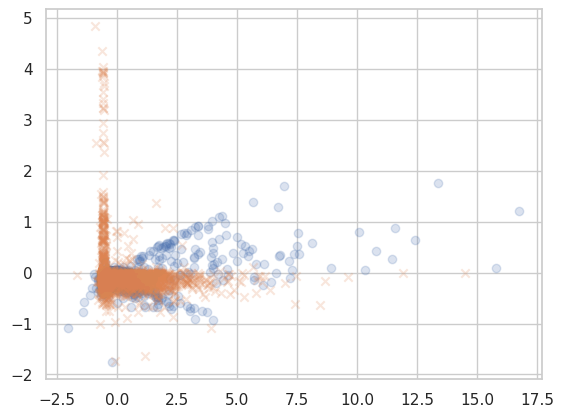

In [80]:
df = pd.read_parquet('../deciferdataset_boundary/boundary_test5k.eval', columns=['descriptors.soap_gen'])
soap_features = np.vstack(df['descriptors.soap_gen'].values)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(soap_features)

# Apply PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)
mask = np.logical_and(reduced_features < 30,reduced_features > -10)
# print(np.any(mask, axis=-1).shape)
features_cut = reduced_features[np.any(mask, axis=-1)]
plt.scatter(features_cut[:,0], features_cut[:,1], marker='o', alpha=0.2)

df = pd.read_parquet('../deciferdataset_no_boundary/no_boundary_test5k.eval', columns=['descriptors.soap_gen'])
soap_features = np.vstack(df['descriptors.soap_gen'].values)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(soap_features)

# Apply PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)
mask = np.logical_and(reduced_features < 30, reduced_features > -10)
print(mask.shape)
features_cut = reduced_features[np.any(mask, axis=-1)]
features_cut = features_cut[features_cut[:,0] < 30, :]
features_cut = features_cut[features_cut[:,1] < 30, :]
features_cut = features_cut[features_cut[:,1] > -5, :]
plt.scatter(features_cut[:,0], features_cut[:,1], marker='x', alpha=0.2)

[[ True  True]
 [ True  True]
 [ True  True]
 ...
 [ True  True]
 [ True  True]
 [ True  True]]


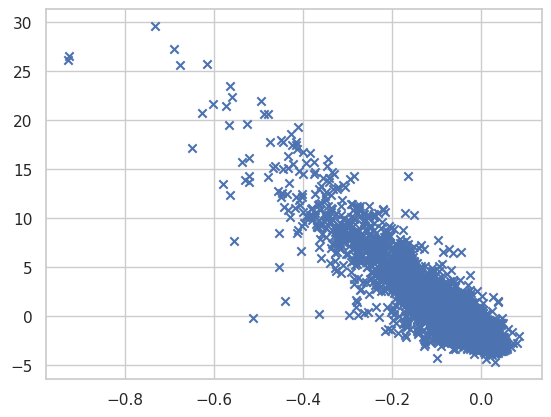

In [82]:


df = pd.read_parquet('../deciferdataset_boundary/boundary_test5k.eval', columns=['descriptors.soap_gen', 'descriptors.soap_sample'])
# soap_features = np.vstack(df['descriptors.soap_gen'].values)
# scaler = StandardScaler()
# features_scaled = scaler.fit_transform(soap_features)

# # Apply PCA
# pca = PCA(n_components=2)
# reduced_features = pca.fit_transform(features_scaled)
# mask = np.logical_and(reduced_features < 30,reduced_features > -10)
# features_cut = reduced_features[np.any(mask, axis=-1)]
# plt.scatter(features_cut[:,0], features_cut[:,1], marker='o')

soap_features = np.vstack(df['descriptors.soap_sample'].values)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(soap_features)

# Apply PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features_scaled)
mask = np.logical_and(reduced_features[1] < 30, reduced_features > -10)
print(mask)
features_cut = reduced_features[np.any(mask, axis=-1)]
features_cut = features_cut[features_cut[:,0] < 30, :]
features_cut = features_cut[features_cut[:,1] < 30, :]
features_cut = features_cut[features_cut[:,1] > -5, :]
plt.scatter(features_cut[:,0], features_cut[:,1], marker='x')

Processing file: ../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval


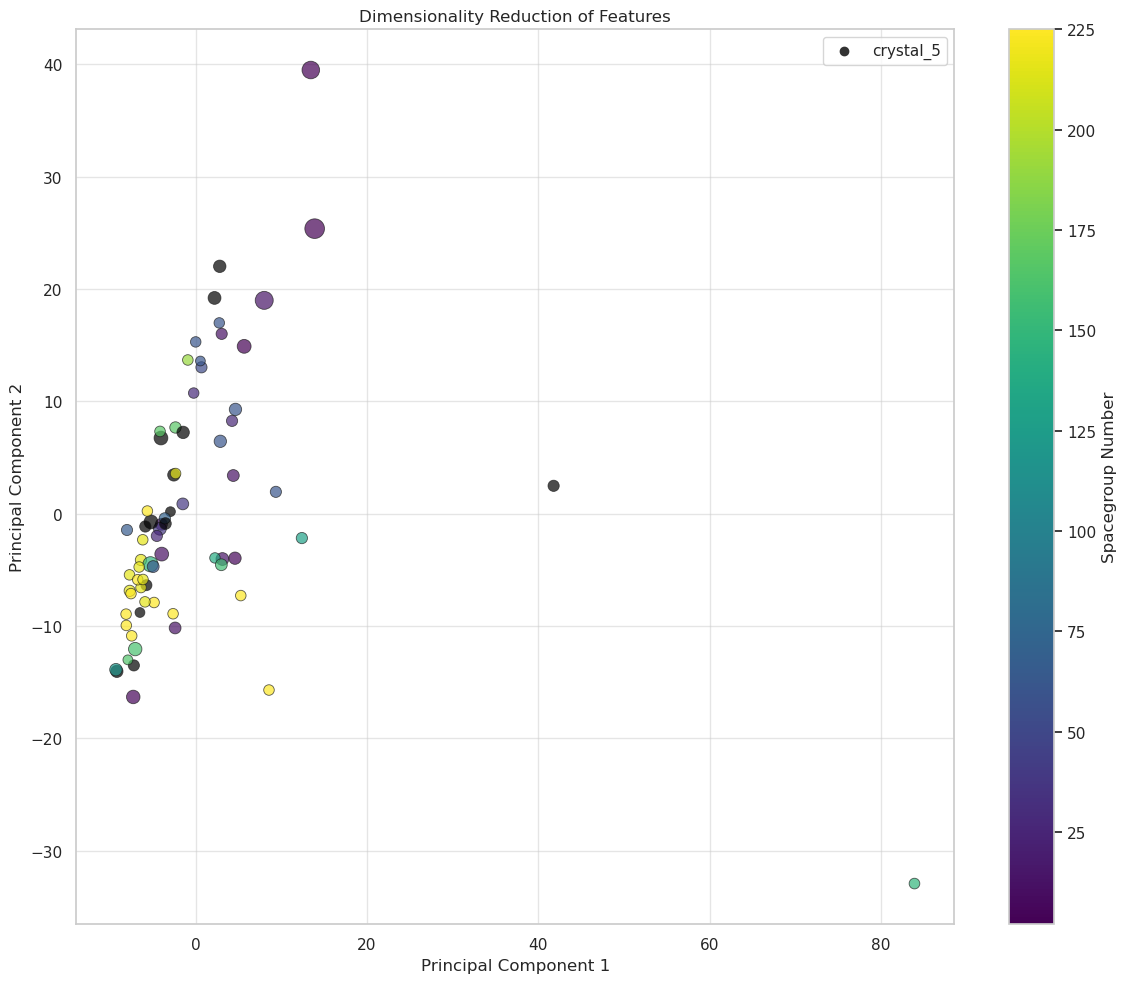

In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup

# Load parquet files and extract relevant features
def load_and_extract_features(file_list):
    """
    Load parquet files and extract relevant features.

    Parameters:
    - file_list (list): List of file paths to parquet files.

    Returns:
    - combined_df (DataFrame): Combined DataFrame with relevant features.
    """
    combined_data = []

    for file in file_list:
        print(f"Processing file: {file}")
        # Read only necessary columns
        columns_to_read = [
            'descriptors.soap_gen',
            'descriptors.acsf_gen',
            'descriptors.xrd_gen.iq',
            'Dataset',
            'spacegroup',
            'seq_len'
        ]
        df = pd.read_parquet(file, columns=columns_to_read)

        # Convert feature columns to numpy arrays
        for col in ['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq']:
            df[col] = df[col].apply(np.array)

        combined_data.append(df)

    combined_df = pd.concat(combined_data, ignore_index=True)

    # Convert 'spacegroup' to integer numbers
    def get_spacegroup_int(sg):
        try:
            return SpaceGroup(sg).int_number
        except:
            return np.nan

    combined_df['spacegroup_int'] = combined_df['spacegroup'].apply(get_spacegroup_int)

    return combined_df

# Combine SOAP, ACSF, and XRD features into one feature matrix
def combine_features(df):
    """
    Combine SOAP, ACSF, and XRD features into one feature matrix.

    Parameters:
    - df (DataFrame): DataFrame containing feature columns.

    Returns:
    - combined_features (ndarray): Combined feature matrix.
    """
    # Stack the feature arrays into 2D numpy arrays
    soap_features = np.vstack(df['descriptors.soap_gen'].values)
    acsf_features = np.vstack(df['descriptors.acsf_gen'].values)
    xrd_features = np.vstack(df['descriptors.xrd_gen.iq'].values)

    # Concatenate features horizontally
    combined_features = np.hstack([soap_features, acsf_features, xrd_features])

    return combined_features

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    """
    Perform dimensionality reduction on the feature matrix.

    Parameters:
    - features (ndarray): The feature matrix.
    - n_components (int): Number of components for PCA.

    Returns:
    - reduced_features (ndarray): Reduced feature matrix.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)

    return reduced_features

# Visualization function using seaborn
def visualize_samples(reduced_features, df):
    """
    Visualize the samples after dimensionality reduction.

    Parameters:
    - reduced_features (ndarray): Reduced feature matrix.
    - df (DataFrame): Original DataFrame with metadata.
    """
    plt.figure(figsize=(12, 10))
    sns.set(style='whitegrid')

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'PC1': reduced_features[:, 0],
        'PC2': reduced_features[:, 1],
        'Dataset': df['Dataset'],
        'Spacegroup': df['spacegroup_int'],
        'Sequence Length': df['seq_len']
    })

    # Normalize the 'Spacegroup' data for the color mapping
    norm = plt.Normalize(plot_df['Spacegroup'].min(), plot_df['Spacegroup'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])

    # Generate colors for each point based on 'Spacegroup'
    point_colors = sm.to_rgba(plot_df['Spacegroup'])

    # Create scatter plot without 'hue' and 'palette' parameters
    scatter = sns.scatterplot(
        data=plot_df,
        x='PC1',
        y='PC2',
        style='Dataset',
        size='Sequence Length',
        edgecolor='k',
        alpha=0.7,
        sizes=(50, 200),
        legend='brief',
        color=point_colors
    )

    # Remove 'Spacegroup' from legend
    handles, labels = scatter.get_legend_handles_labels()

    # Extract unique labels for 'Dataset' and 'Sequence Length'
    dataset_labels = plot_df['Dataset'].unique().tolist()
    size_labels = ['{:.0f}'.format(s) for s in sorted(plot_df['Sequence Length'].unique())]

    # Filter handles and labels for 'Dataset' (styles)
    style_handles = [h for h, l in zip(handles, labels) if l in dataset_labels]
    style_labels = [l for l in labels if l in dataset_labels]

    # Filter handles and labels for 'Sequence Length' (sizes)
    size_handles = [h for h, l in zip(handles, labels) if l in size_labels]
    size_labels_formatted = ['Sequence Length: ' + l for l in size_labels]

    # Update the legend
    new_handles = style_handles + size_handles
    new_labels = style_labels + size_labels_formatted
    scatter.legend(handles=new_handles, labels=new_labels, loc='best')

    # Add colorbar for 'Spacegroup'
    cbar = scatter.figure.colorbar(sm, ax=scatter)
    cbar.set_label('Spacegroup Number')

    plt.title("Dimensionality Reduction of Features")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    
    # Set grid transparency (alpha)
    plt.grid(alpha=0.5)

    plt.tight_layout()
    plt.show()

# Main function to process multiple files and visualize
def main():
    # Assuming files are in the specified directory with the ".eval" extension
    file_list = glob.glob("../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval")

    # Load and extract relevant features
    df = load_and_extract_features(file_list)

    # Combine SOAP, ACSF, and XRD features into one feature matrix
    features = combine_features(df)

    # Perform dimensionality reduction (PCA to 2 components)
    reduced_features = perform_dimensionality_reduction(features, n_components=2)

    # Visualize the samples
    visualize_samples(reduced_features, df)

# Entry point for the script
if __name__ == "__main__":
    main()


Processing file: ../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval


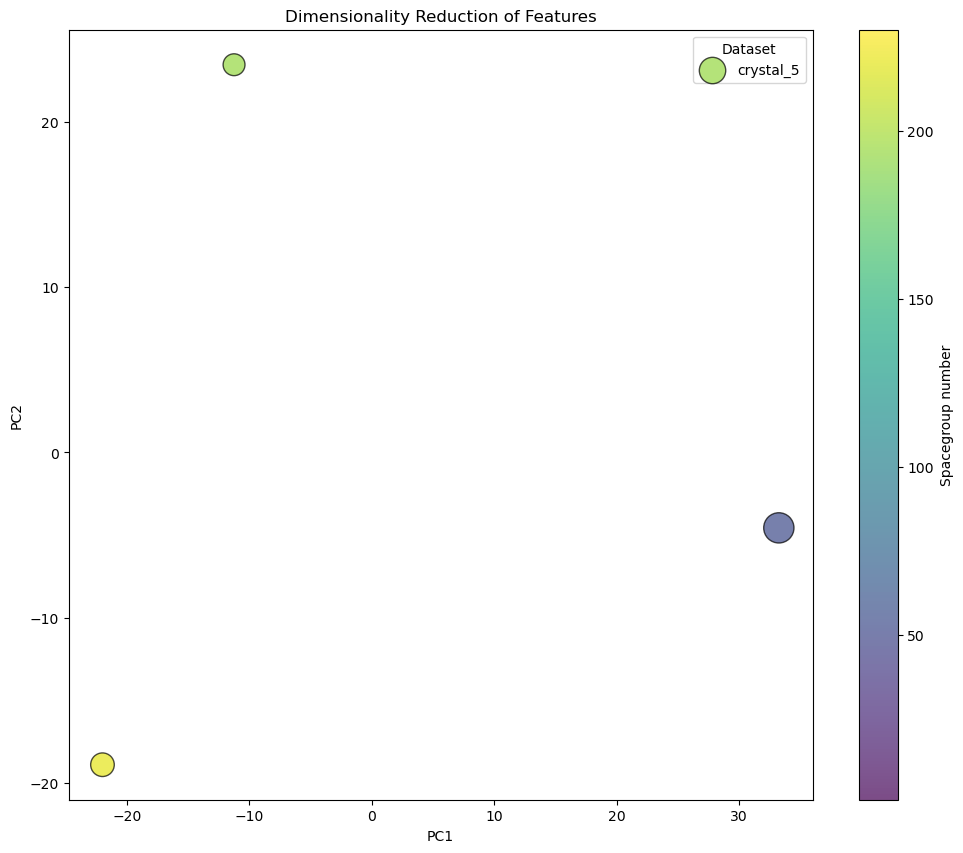

In [41]:
import pandas as pd
import numpy as np
import os
import glob
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup

# Load parquet files and extract relevant features
def load_and_extract_features(file_list):
    combined_data = []
    
    for file in file_list:
        print(f"Processing file: {file}")
        # Load the parquet file
        #df = pq.read_table(file).to_pandas()
        df = pd.read_parquet(file)
#         print(df)

        # Extract SOAP, ACSF, and XRD-cont-y features, along with dataset, spacegroup, and seq_len
        relevant_data = df[['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq', 'Dataset', 'spacegroup', 'seq_len']]
#         print(relevant_data)

        # Convert the feature columns to numpy arrays for easier processing
        # Correcting the modification using .loc to avoid the warning
        relevant_data.loc[:, 'descriptors.soap_gen'] = relevant_data['descriptors.soap_gen'].apply(np.array)
        relevant_data.loc[:, 'descriptors.acsf_gen'] = relevant_data['descriptors.acsf_gen'].apply(np.array)
        relevant_data.loc[:, 'descriptors.xrd_gen.iq'] = relevant_data['descriptors.xrd_gen.iq'].apply(np.array)

        # Safely modify 'spacegroup_int' without triggering the warning
        relevant_data = relevant_data.assign(
            spacegroup_int=relevant_data['spacegroup'].apply(lambda sg: SpaceGroup(sg).int_number)
        )
        
        combined_data.append(relevant_data)

    # Concatenate all dataframes
    return pd.concat(combined_data, ignore_index=True)

# Combine SOAP, ACSF, and XRD features into one feature matrix
def combine_features(df):
    feature_list = []
    
    for i, row in df.iterrows():
        combined_features = np.concatenate([row['descriptors.soap_gen'], row['descriptors.acsf_gen'], row['descriptors.xrd_gen.iq']])
        feature_list.append(combined_features)
    
    return np.array(feature_list)

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)
    
    return reduced_features

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)
    
    return reduced_features

# Visualization function
def visualize_samples(reduced_features, df):
    # Set up plot
    plt.figure(figsize=(12, 10))
    
    # Create scatter plot with different shapes for datasets and colors for spacegroups
    # Set the marker size based on sequence length (seq_len)
    datasets = df['Dataset'].unique()
    markers = ['o', 's', '^', 'D', 'v']  # Different marker styles for datasets
    marker_map = {dataset: markers[i % len(markers)] for i, dataset in enumerate(datasets)}
    
    # Map spacegroup integers to a continuous color scale
    #norm = plt.Normalize(vmin=df['spacegroup_int'].min(), vmax=df['spacegroup_int'].max())
    norm = plt.Normalize(1, 230)
    cmap = matplotlib.colormaps['viridis']

    # Scatter plot and collect color-mappable object
    scatter = None
    for dataset in datasets:
        subset = df[df['Dataset'] == dataset]
        scatter = plt.scatter(
            reduced_features[df['Dataset'] == dataset, 0],
            reduced_features[df['Dataset'] == dataset, 1],
            s=subset['seq_len'],  # Size of the points based on seq_len
            c=subset['spacegroup_int'],  # Color based on integer spacegroup
            cmap=cmap,
            norm=norm,
            label=dataset,
            marker=marker_map[dataset],
            alpha=0.7,
            edgecolors='k'
        )

    # Add colorbar for spacegroups
    plt.colorbar(scatter, label='Spacegroup number')
    
    # Add labels and legend
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Dimensionality Reduction of Features")
    plt.legend(title="Dataset", loc="best")
    
    plt.show()

# Main function to process multiple files and visualize
def main():
    # Assuming files are in the current directory and have the ".eval" extension
    file_list = glob.glob("../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval")
    
    # Load and extract relevant features
    df = load_and_extract_features(file_list)
    
    # Combine SOAP, ACSF, and XRD features into one feature matrix
    features = combine_features(df)
    
    # Perform dimensionality reduction (PCA to 2 components)
    reduced_features = perform_dimensionality_reduction(features, n_components=2)
    
    # Visualize the samples
    visualize_samples(reduced_features, df)

# Entry point for the script
if __name__ == "__main__":
    main()


In [15]:
import pyarrow.parquet as pq

# Load the parquet file to inspect its structure
file_path = '../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval'  # Update with the correct file path

# Read the parquet file
parquet_file = pq.read_table(file_path)

# Display the structure of the parquet file (column names and sample rows)
print("Column names:", parquet_file.column_names)
print(parquet_file.to_pandas().head())  # Show the first few rows

Column names: ['cif', 'spacegroup', 'index', 'rep', 'Dataset', 'Model', 'seq_len', 'status', 'syntax_validity.formula_consistency', 'syntax_validity.atom_site_multiplicity', 'syntax_validity.bond_length_acceptability', 'syntax_validity.space_group_consistency', 'cell_params.a', 'cell_params.b', 'cell_params.c', 'cell_params.alpha', 'cell_params.beta', 'cell_params.gamma', 'cell_params.implied_vol', 'cell_params.gen_vol', 'descriptors.xrd_gen.q', 'descriptors.xrd_gen.iq', 'descriptors.xrd_sample.q', 'descriptors.xrd_sample.iq', 'descriptors.soap_gen', 'descriptors.soap_sample', 'descriptors.acsf_gen', 'descriptors.acsf_sample']
                                                 cif spacegroup  index  rep  \
0  data_Sr4Gd4Tm4\n_symmetry_space_group_name_H-M...   P6_3/mmc      0    0   
1  data_Li16P62N14N9\n_symmetry_space_group_name_...       Pnna      3    0   
2  data_Ce1Al3Ge6Pd1\n_symmetry_space_group_name_...      Pm-3m      2    0   

     Dataset         Model  seq_len   status  \


In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings
import argparse

In [2]:
# Read the Parquet file into a DataFrame
df = pd.read_parquet('../uncon_trained_models/crystal500k_25M_2048/crystal_5.eval')
ar = np.stack(df.iloc[:]['descriptors.xrd_sample.iq'])
df

,cif,spacegroup,index,rep,Dataset,Model,seq_len,status,syntax_validity.formula_consistency,syntax_validity.atom_site_multiplicity,...,cell_params.implied_vol,cell_params.gen_vol,descriptors.xrd_gen.q,descriptors.xrd_gen.iq,descriptors.xrd_sample.q,descriptors.xrd_sample.iq,descriptors.soap_gen,descriptors.soap_sample,descriptors.acsf_gen,descriptors.acsf_sample
0,data_Sr4Gd4Tm4\n_symmetry_space_group_name_H-M...,P6_3/mmc,0,0,crystal_5,DefaultModel,248,success,True,False,...,347.907737,395.31440,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[8.187683450746056e-79, 3.4052520045497944e-77...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 3.4765625, 0.0, 0.0,..."
1,data_Li16P62N14N9\n_symmetry_space_group_name_...,Pnna,3,0,crystal_5,DefaultModel,475,success,False,False,...,1781.334799,463.47147,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[1.6302421786050783e-36, 2.0102527932365026e-3...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.5049684796465357, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 2.7011719, 0.0, 0.0, 0.0, 0.0, 0.0, 7.07..."
2,data_Ce1Al3Ge6Pd1\n_symmetry_space_group_name_...,Pm-3m,2,0,crystal_5,DefaultModel,289,success,False,False,...,123.275492,924.20750,"[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[3.6495854368582506e-139, 5.580743891979268e-1...","[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


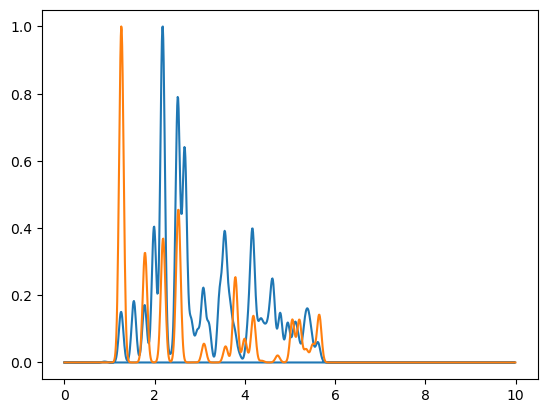

In [3]:
plt.plot(df.iloc[2]['descriptors.xrd_sample.q'], df.iloc[2]['descriptors.xrd_sample.iq'])
plt.plot(df.iloc[2]['descriptors.xrd_gen.q'], df.iloc[2]['descriptors.xrd_gen.iq'])
plt.show()

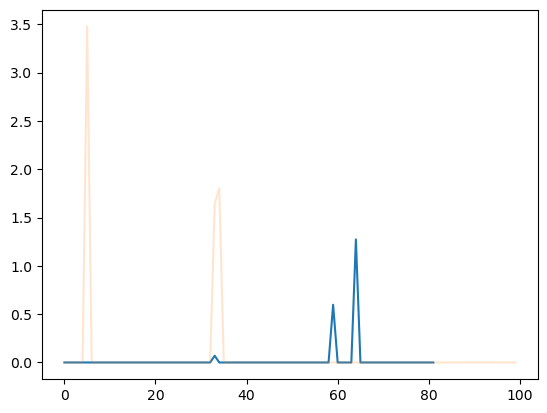

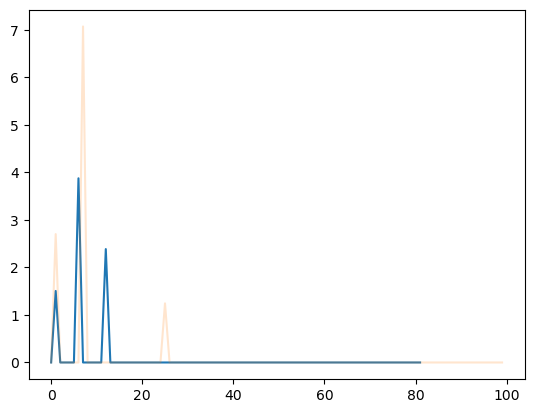

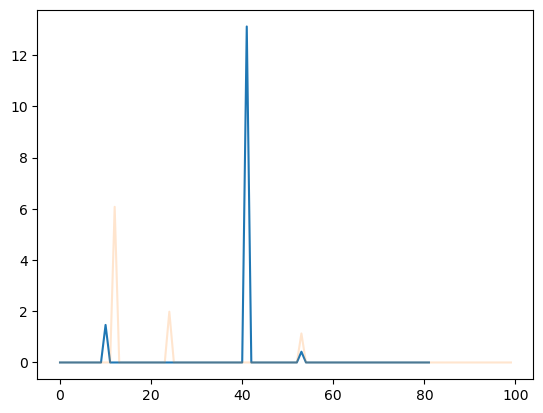

In [4]:

for i, sample in enumerate(df.iloc):
    fig = plt.figure()
    a = plt.plot(sample['descriptors.acsf_gen'][:100])
    plt.plot(sample['descriptors.acsf_sample'][:100], alpha=0.2)
plt.show()

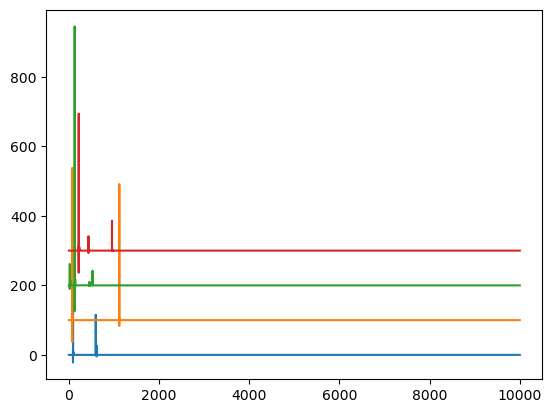

In [5]:
fig = plt.figure()
for i, sample in enumerate(df.iloc):
    plt.plot(sample['descriptors.soap_sample'] + i*100)
plt.show()

In [22]:
from pymatgen.core import Composition
from decifer import extract_formula_nonreduced

set(Composition(extract_formula_nonreduced(df.iloc[0]['cif'])).as_dict().keys())

{'O', 'Pt', 'S'}

[ True  True  True]
['Pt', 'Ac', 'Cr']
(1, 147)


/home/frjo/miniconda3/envs/decifer_env/lib/python3.9/site-packages/pymatgen/io/cif.py:1257: UserWarning: The default value of primitive was changed from True to False in https://github.com/materialsproject/pymatgen/pull/3419. CifParser now returns the cell in the CIF file as is. If you want the primitive cell, please set primitive=True explicitly.
  warnings.warn(


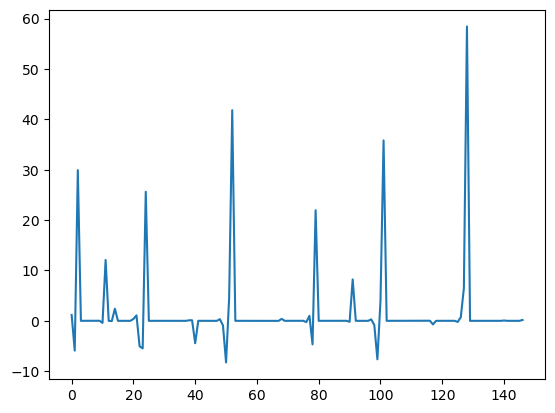

In [3]:
from pymatgen.io.cif import CifParser#, parse_structures
try:
    from_string = CifParser.from_str
except:
    from_string = CifParser.from_string
from dscribe.descriptors import SOAP

# Load the crystal structure
cif = df.iloc[2]['cif']
structure = from_string(cif).parse_structures()[0]
ase_structure = structure.to_ase_atoms()
print(ase_structure.pbc)
# Define species and parameters
species = list(set([str(site.specie) for site in structure]))
print(species)
soap = SOAP(
    species=species,
    r_cut=5.0,
    n_max=2,
    l_max=6,
    periodic=True,
    sparse=False
)

# Compute the SOAP descriptors
soap_descriptors = soap.create(ase_structure, centers=[0])
print(soap_descriptors.shape)

plt.plot(soap_descriptors[0])

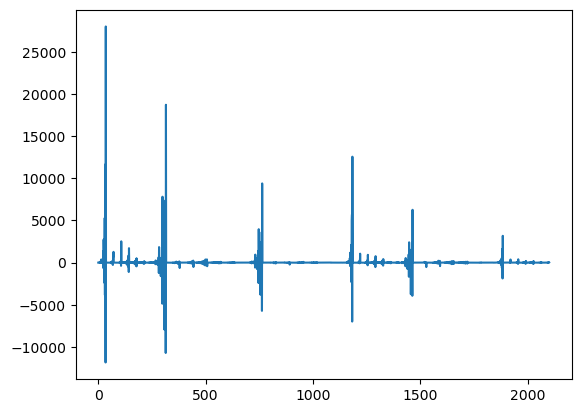

In [40]:
plt.plot(soap.create_single(ase_structure).sum(axis=0))

In [47]:
soap.derivatives(ase_structure)

AttributeError: 'tuple' object has no attribute 'shape'

In [30]:
from dscribe.descriptors import SOAP

species = ["H", "C", "O", "N"]
r_cut = 6.0
n_max = 2
l_max = 1

# Setting up the SOAP descriptor
soap = SOAP(
    species=species,
    periodic=False,
    r_cut=r_cut,
    n_max=n_max,
    l_max=l_max,
)

from ase.build import molecule

# Molecule created as an ASE.Atoms
water = molecule("H2O")

# Create SOAP output for the system
soap_water = soap.create(water, centers=[0])

# print(soap_water)
print(soap_water.shape)

(1, 72)


NameError: name 'from_string' is not defined

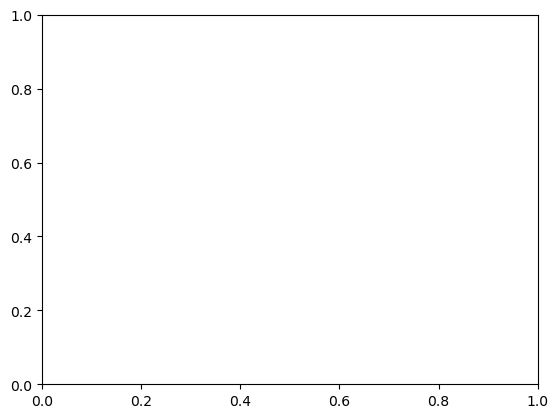

In [31]:
from pymatgen.core import Structure
from dscribe.descriptors import MBTR

fig, ax = plt.subplots()

for line in df.iloc:
    
    if line['syntax_validity.atom_site_multiplicity']:
        cif = line['cif']

        # Load your crystal structure
        structure = from_string(cif).parse_structures()[0]

        # Convert pymatgen Structure to ASE Atoms object
        ase_structure = structure.to_ase_atoms()

        # Define the species present in your structure
        species = list(set([str(site.specie) for site in structure]))
        print(species)

        # Set up MBTR with the new syntax
        mbtr = MBTR(
            species=species,
            geometry={
                "function": "inverse_distance",  # Geometry function for K=2
            },
            grid={"min": 0, "max": 0.5, "sigma": 0.01, "n": 200},
            weighting={
                "function": "exp",
                "scale": 0.5,
                "threshold": 1e-3,
            },
            periodic=True,
            normalization="l2",
        )

        # Compute the MBTR descriptor
        mbtr_descriptor = mbtr.create(ase_structure)

        ax.plot(mbtr_descriptor)

# print(mbtr_descriptor)
# print(mbtr_descriptor.shape)


In [58]:
from dscribe.descriptors import ACSF

cif = df.iloc[2]['cif']
structure = from_string(cif).parse_structures()[0]
ase_structure = structure.to_ase_atoms()

# Extract all unique atomic species from the structure
species = list(set([str(site.specie) for site in structure]))
print("Species in structure:", species)

acsf = ACSF(
    species=species,
    r_cut=6.0,
    periodic=True,
)

acsf_descriptor = acsf.create(ase_structure, centers=[0])
acsf_descriptor

Species in structure: ['Al', 'Hg', 'Mn']


array([[4.32915729, 1.12940154, 2.38223618]])